# Rankeo de *leads*.

Imagina que trabajas para un banco y este banco ofrece inversiones a plazo fijo a sus clientes. Como parte de una campaña para ampliar la cantidad de inversiones a plazo fijo que sus clientes han adquirido, la compañía utiliza diversos métodos de contacto, entre los cuales el teléfono es todavía una de las formas más efectivas.

Al banco le encantaría llamar a todos sus clientes, sin embargo, esto no es posible porque el call center no se da abasto y es importante priorizar a quienes hay que llamar para garantizar el máximo número de conversiones.

**Tu tarea es encontrar una forma de clasificar y rankear (ordenar) las llamadas de tal modo que los agentes del centro de llamadas, llame primero a quien tiene más probabilidades de depositar su dinero.**

![](https://ik.imagekit.io/thatcsharpguy/projects/codigo-facilito/machine-learning/deposito-header.jpg?ik-sdk-version=javascript-1.4.3&updatedAt=1669051927251)

## Código

### [https://github.com/fferegrino/cf-ml/tree/main/term-deposit](https://github.com/fferegrino/cf-ml/tree/main/term-deposit)

## Dataset

Este dataset es una versión modificada de [Term Deposit Prediction Data Set](https://www.kaggle.com/datasets/brajeshmohapatra/term-deposit-prediction-data-set) disponible en Kaggle.



## Solución  

La empresa tiene información de clientes anteriores que en algún momento han sido contactados en el pasado comprar la inversión en el pasado sin importar si lo compraron o no. Esta información está contenida en el archivo `train.csv`.

Así mismo, para ayudarte hay un archivo llamado `test.csv` con datos de otros clientes pero que deberás usar para probar tus resultados.

**Como no tenemos más información más allá de si un cliente compró o no compró, vamos a utilizar las probabilidades que nos de un modelo de clasificación para decidir quién tiene más probabilidades de convertir**.

Este problema se conoce como *lead scoring*.

### Descripción de los datos

| Variable     | Definición                                                              |
|--------------|-------------------------------------------------------------------------|
| *ID*         | Identificador único del cliente                                         |
| *age*        | Edad del cliente                                                        |
| *job*        | Trabajo que desempeña el cliente                                        |
| *marital*    | Estado marital del cliente                                              |
| *education*  | Nivel de educación del cliente                                          |
| *default*    | Especifica si el cliente tiene una deuda no pagada                      |
| *balance*    | Saldo promedio anual del cliente                                        |
| *housing*    | Indica si el cliente tiene una hipoteca con el banco                    |
| *loan*       | Indica si el cliente tiene un préstamo personal                         |
| *contact*    | El medio por el cual se ha estado contactando al cliente                |
| *month*      | El mes en el que se contactó al cliente                                 |
| *day*        | El día en el que se contactó al cliente                                 |
| *duration*   | Duración del contacto con el cliente                                    |
| *campaign*   | El número de veces que el banco se ha puesto en contacto con el cliente |
| *pdays*      | Número de días que han transcurrido desde el último contacto            |
| *previous*   | Número de veces que se ha contactado al cliente antes de esta campaña   |
| *poutcome*   | Si el cliente ha comprado productos como resutlado de la campaña previa |
| *subscribed* | Si el cliente se suscribió como resultado de la campaña más reciente    |


In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv("train.csv")
train.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,26110,56,admin.,married,unknown,no,1933,no,no,telephone,19,nov,44,2,-1,0,unknown,no
1,40576,31,unknown,married,secondary,no,3,no,no,cellular,20,jul,91,2,-1,0,unknown,no
2,15320,27,services,married,secondary,no,891,yes,no,cellular,18,jul,240,1,-1,0,unknown,no
3,43962,57,management,divorced,tertiary,no,3287,no,no,cellular,22,jun,867,1,84,3,success,yes
4,29842,31,technician,married,secondary,no,119,yes,no,cellular,4,feb,380,1,-1,0,unknown,no


## EDA

In [3]:
from pandas_profiling import ProfileReport
import seaborn as sns

In [4]:
profile = ProfileReport(train, title="Raw Deposit Dataset Analysis", explorative=True)
profile.to_file("deposit-report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\cajiv\OneDrive\env_python\cienciadatos\lib\site-packages\multimethod\__init__.py:315: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return func(*args, **kwargs)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Desbalance de clases

Text(0.5, 1.0, 'Target variable distribution\nNo: 27932 (88.26%) | Yes: 3715 (11.74%) ')

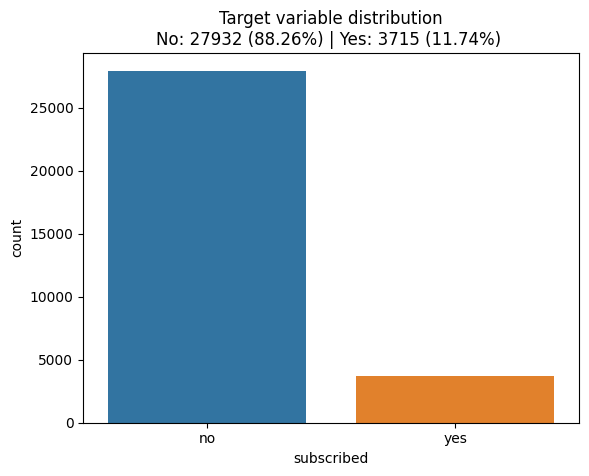

In [5]:
subscribed_proportion = (train['subscribed'].value_counts()).to_dict()
ax = sns.countplot(x=train["subscribed"])
title = ("Target variable distribution\n"
    f"No: {subscribed_proportion['no']} ({(subscribed_proportion['no']/len(train)):0.2%}) |"
    f" Yes: {subscribed_proportion['yes']} ({(subscribed_proportion['yes']/len(train)):0.2%}) " )
ax.set_title(title)

### Relación entre columnas

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3, figsize=(10, 2))

sns.countplot(x='subscribed', hue='housing', data=train, ax=axs[0])
sns.countplot(x='subscribed', hue='loan', data=train, ax=axs[1])
sns.countplot(x='subscribed', hue='default', data=train, ax=axs[2])

## Elimina la columna de ID

El ID no contiene ninguna información que nos pueda ayudar a encontrar los mejores resultados puesto que es único para cada cliente.

In [ ]:
train.drop(['ID'], axis='columns', inplace=True)

## *One-hot encode* el estatus marital

In [ ]:
from sklearn.preprocessing import OneHotEncoder
marital_encoder = OneHotEncoder()

marital_encoder.fit(train[['marital']])
encoded_marital = marital_encoder.transform(train[['marital']])

In [ ]:
encoded_marital = pd.DataFrame(encoded_marital.toarray(), columns=marital_encoder.categories_)
encoded_marital['original_value'] = train['marital']
encoded_marital

## *Binnea* y codifica la variable edad

In [ ]:
from custom_transformers import CutTransformer

In [ ]:
age_bin = CutTransformer(bins = [0, 20, 30, 40, 50, 60, 1000], as_str=True)

In [ ]:
age_frame = train[['age']].copy()
age_bin.fit(age_frame[['age']])

age_encoded = age_bin.fit_transform(age_frame[['age']])
age_frame['age_encoded'] = age_encoded

In [ ]:
age_frame

In [ ]:
age_one_hot_encoder = OneHotEncoder()

In [ ]:
age_one_hot_encoder.fit(age_frame[['age_encoded']])

In [ ]:
one_hot_encoded_ages = pd.DataFrame(
    age_one_hot_encoder.transform(age_frame[['age_encoded']]).toarray(),
    columns=age_one_hot_encoder.categories_
)

In [ ]:
pd.merge(age_frame, one_hot_encoded_ages, left_index=True, right_index=True)

## Escala los datos numéricos

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
balance_scaler = StandardScaler()

In [ ]:
balance_scaled = train[['balance']].copy()

In [ ]:
balance_scaled['balance_scaled'] = balance_scaler.fit_transform(balance_scaled[['balance']])

In [ ]:
balance_scaled

## Convierte *"yes"* y *"no"* a enteros

In [ ]:
from custom_transformers import YesNoTransformer

yes_no_transformer = YesNoTransformer()

In [ ]:
housing_loan_frame = train[['housing', 'loan']].copy()

In [ ]:
housing_loan_frame[['housing_mapped', 'loan_mapped']] = yes_no_transformer.fit_transform(housing_loan_frame)

In [ ]:
housing_loan_frame

## Empaca todos los artefactos en un pipeline

La gestión de los artefactos puede volverse un problema cuando estamos lidiando con múltiples transformadores y estimadores. En nuestro caso tenemos *One-Hot encoders*, un *Cut transformer*, escalador *estandar*...

Una forma de no tener que preocuparnos por elementos individuales es agruparlos todos en un pipeline y almacenarlo todo en conjunto.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn import set_config

# One-Hot encode marital status
one_hot_encode_categoricals = ColumnTransformer([
    (
        'one_hot_encode_marital', # Nombre de la transformación
        OneHotEncoder(sparse=False), # Transformación a aplicar
        ["marital", 'contact', 'education', 'poutcome'] # Columnas involucradas
    )
])

# Bin and encode age
bin_and_encode_age_pipeline = Pipeline([
    ('bin_age', CutTransformer(bins =  [0, 20, 30, 40, 50, 60, 1000], as_str=True)),
    ('encode_age', OneHotEncoder()),
])

bin_and_encode_age = ColumnTransformer([
    ('bin_and_encode_age', bin_and_encode_age_pipeline, ["age"])
])

# Scale balance
scale_balance = ColumnTransformer([
    (
        'scale_balance', # Nombre de la transformación
        StandardScaler(), # Transformación a aplicar
        ["balance"] # Columnas involucradas
    )
])

# Map housing and loan
map_housing_loan = ColumnTransformer([
    (
        'map_housing_loan', # Nombre de la transformación
        YesNoTransformer(), # Transformación a aplicar
        ["housing", 'loan', 'default'] # Columnas involucradas
    )
])

passthrough = ColumnTransformer([('passthrough', 'passthrough', ['campaign', "pdays", "duration", "previous"])])

# Ensambla todo el pipeline
feature_pipeline = Pipeline([
    (
        'features',
        FeatureUnion([
            ('one_hot_encode_categoricals', one_hot_encode_categoricals),
            ('bin_and_encode_age', bin_and_encode_age),
            ('scale_balance', scale_balance),
            ('passthrough', passthrough),
            ('map_housing_loan', map_housing_loan),
        ])
    )
])

In [6]:
from sklearn import set_config

set_config(display="diagram")
feature_pipeline

NameError: name 'feature_pipeline' is not defined

In [ ]:
feature_pipeline.fit(train)

temp_train = pd.DataFrame(feature_pipeline.transform(train).toarray())
temp_train

In [ ]:
train

## Convierte el *target* a enteros

In [ ]:
subscribed_frame = train[['subscribed']].copy()
subscribed_frame['encoded'] = np.where(subscribed_frame['subscribed'] == 'yes', 1, 0)

subscribed_frame.head(10)

In [ ]:
training_target_encoded = np.where(subscribed_frame['subscribed'] == 'yes', 1, 0)

## Encuentra los mejores parámetros

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
search_pipeline = Pipeline([
    ('feature_pipeline', feature_pipeline),
    ('model', XGBClassifier())
])

In [ ]:
param_grid = {
    "model__n_estimators": [100, 200, 300],
    'model__max_depth': [4, 5, 6],
    # 'model__subsample': [0.5, 1],
    # 'model__scale_pos_weight': [1, 7.5],
    # 'model__eta': [0.01, 0.1, 0.2, 0.3]
}
search = GridSearchCV(search_pipeline, param_grid, n_jobs=-1, scoring='precision')
_ = search.fit(train, training_target_encoded)

In [ ]:
best_params = {key[7:]:value for key, value in search.best_params_.items()}
print("Best parameters:", best_params)
print(f"Best score: {search.best_score_:0.3%}")

## Reentrena el mejor modelo con los mejores parámetros

A pesar de que puedes utilizar el modelo entrenado usando `search.best_estimator_`, es una buena idea **reentrenar** un modelo nuevo **utilizando los mejores parámetros** recien obtenidos y **todos los datos disponibles para entrenamiento**.

In [ ]:
inference_pipeline = Pipeline([
    ('feature_pipeline', feature_pipeline),
    ('model', XGBClassifier(**best_params))
])
_ = inference_pipeline.fit(train, training_target_encoded)

In [ ]:
predicciones = inference_pipeline.predict(train)

In [ ]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix

def evaluate(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    print(confusion_matrix(y_true, y_pred))

    print(f"{recall:0.2%} {accuracy:0.2%} {precision:0.2%}")

In [ ]:
evaluate(training_target_encoded, predicciones)

## Evaluando con los datos de prueba

In [ ]:
test = pd.read_csv("test.csv")

In [ ]:
predicciones_test = inference_pipeline.predict(test)
predicciones_test

evaluate(np.where(test['subscribed'] == 'yes', 1, 0), predicciones_test)

In [ ]:
test['subscribed'].value_counts()

## Guardando todo el pipeline

In [ ]:
import pickle

with open("lead_scoring.pickle", "wb") as wb:
    pickle.dump(inference_pipeline, wb)

## ¿Y el lead scoring?

In [ ]:
with open("lead_scoring.pickle", "rb") as rb:
    lead_scoring = pickle.load(rb)

In [ ]:
probabilidades = lead_scoring.predict_proba(test)

 > ℹ️ `predict_proba` regresa un arreglo de tamaño *(n_samples, n_classes)*, en donde las clases están dadas en el orden dictado por `lead_scoring.classes_`

In [ ]:
lead_scoring.classes_

In [ ]:
test['score'] = probabilidades[:, 1]

In [ ]:
test[["ID", "score"]].sort_values('score', ascending=False)

#### 